<a href="https://colab.research.google.com/github/santiagonajera/MODELACION-Y-PRONOSTICOS-DE-LA-DEMANDA/blob/main/MultiplesModelos_MAchineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

# Leer Excel desde URL
url = "https://github.com/santiagonajera/MODELACION-Y-PRONOSTICOS-DE-LA-DEMANDA/raw/refs/heads/main/Ejemplo-supermercado.xlsx"
df = pd.read_excel(url)
productos = ['PRODUCTO1', 'PRODUCTO2', 'PRODUCTO3', 'PRODUCTO4', 'PRODUCTO5']

# Suavizamiento Exponencial Simple
def ses_forecast(series, alpha):
    result = [series[0]]
    for t in range(1, len(series)):
        result.append(alpha * series[t-1] + (1-alpha) * result[-1])
    return np.array(result)

def ses_rmse(alpha, series):
    fitted = ses_forecast(series, alpha)
    return np.sqrt(mean_squared_error(series[1:], fitted[:-1]))

def find_best_alpha(series):
    opt = minimize(lambda a: ses_rmse(a[0], series), x0=[0.5], bounds=[(0.01, 0.99)])
    return opt.x[0]

# Croston Forecasting
def croston(series, alpha=0.1):
    n = len(series)
    demand = series
    idx = np.where(demand != 0)[0]
    if len(idx) == 0:
        return np.zeros(n)
    x = demand[idx]
    p = np.diff(np.concatenate(([0], idx)))
    a, b = x[0], p[0]
    forecasts = []
    for i in range(len(x)):
        a = a + alpha*(x[i]-a)
        b = b + alpha*(p[i]-b)
        forecasts.append(a/b)
    croston_fit = np.zeros(n)
    croston_fit[idx] = forecasts
    for i in range(n):
        if croston_fit[i] == 0 and i > 0:
            croston_fit[i] = croston_fit[i-1]
    return croston_fit

# Resultados para cada producto
results = []
for prod in productos:
    serie = df[prod].values
    alpha_opt = find_best_alpha(serie)
    ses_fit = ses_forecast(serie, alpha_opt)
    ses_rmse_val = ses_rmse(alpha_opt, serie)
    ses_forecast_next = alpha_opt * serie[-1] + (1-alpha_opt) * ses_fit[-1]
    croston_fit = croston(serie)
    croston_rmse_val = np.sqrt(mean_squared_error(serie[1:], croston_fit[:-1]))
    croston_forecast_next = croston_fit[-1]
    results.append({
        'Producto': prod,
        'SES_alpha': alpha_opt,
        'SES_RMSE': ses_rmse_val,
        'SES_forecast_next': ses_forecast_next,
        'Croston_RMSE': croston_rmse_val,
        'Croston_forecast_next': croston_forecast_next
    })

# Mostrar resultados
final_df = pd.DataFrame(results)
print(final_df)


/tmp/ipython-input-1941468917.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  forecasts.append(a/b)


ValueError: Input contains infinity or a value too large for dtype('float64').

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

# Leer Excel desde URL
url = "https://github.com/santiagonajera/MODELACION-Y-PRONOSTICOS-DE-LA-DEMANDA/raw/refs/heads/main/Ejemplo-supermercado.xlsx"
df = pd.read_excel(url)
productos = ['PRODUCTO1', 'PRODUCTO2', 'PRODUCTO3', 'PRODUCTO4', 'PRODUCTO5']

def ses_forecast(series, alpha):
    result = [series[0]]
    for t in range(1, len(series)):
        result.append(alpha * series[t-1] + (1-alpha) * result[-1])
    return np.array(result)

def ses_rmse(alpha, series):
    fitted = ses_forecast(series, alpha)
    return np.sqrt(mean_squared_error(series[1:], fitted[:-1]))

def find_best_alpha(series):
    opt = minimize(lambda a: ses_rmse(a[0], series), x0=[0.5], bounds=[(0.01, 0.99)])
    return opt.x[0]

def croston(series, alpha=0.1):
    n = len(series)
    demand = np.array(series)
    idx = np.where(demand != 0)[0]
    if len(idx) == 0:
        return np.zeros(n)
    x = demand[idx]
    p = np.diff(np.concatenate(([0], idx)))
    a, b = x[0], p[0] if p[0]!=0 else 1
    forecasts = []
    for i in range(len(x)):
        a = a + alpha*(x[i]-a)
        b = b + alpha*(p[i]-b)
        b = max(b, 1e-6) # Prevenir división por cero
        forecasts.append(a/b)
    croston_fit = np.zeros(n)
    croston_fit[idx] = forecasts
    for i in range(n):
        if croston_fit[i] == 0 and i > 0:
            croston_fit[i] = croston_fit[i-1]
    croston_fit = np.nan_to_num(croston_fit, nan=0.0, posinf=0.0, neginf=0.0)
    return croston_fit

results = []
for prod in productos:
    serie = df[prod].values
    alpha_opt = find_best_alpha(serie)
    ses_fit = ses_forecast(serie, alpha_opt)
    ses_rmse_val = ses_rmse(alpha_opt, serie)
    ses_forecast_next = alpha_opt * serie[-1] + (1-alpha_opt) * ses_fit[-1]
    croston_fit = croston(serie)
    # Validar que todos los valores son finitos
    croston_fit = np.nan_to_num(croston_fit, nan=0.0, posinf=0.0, neginf=0.0)
    croston_rmse_val = np.sqrt(mean_squared_error(serie[1:], croston_fit[:-1]))
    croston_forecast_next = croston_fit[-1]
    results.append({
        'Producto': prod,
        'SES_alpha': alpha_opt,
        'SES_RMSE': ses_rmse_val,
        'SES_forecast_next': ses_forecast_next,
        'Croston_RMSE': croston_rmse_val,
        'Croston_forecast_next': croston_forecast_next
    })

final_df = pd.DataFrame(results)
print(final_df)


    Producto  SES_alpha   SES_RMSE  SES_forecast_next  Croston_RMSE  \
0  PRODUCTO1   0.329753   8.178778          17.958780      8.122640   
1  PRODUCTO2   0.010000  10.135395          22.473208     10.450212   
2  PRODUCTO3   0.278180   8.323114          24.353301      9.543588   
3  PRODUCTO4   0.049677  10.563616          21.412682     10.308268   
4  PRODUCTO5   0.094787   7.708076          18.543937      7.564651   

   Croston_forecast_next  
0              22.388196  
1              23.016735  
2              23.650968  
3              22.649198  
4              18.538901  


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfaj38bqv/19bzvt8k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfaj38bqv/cf_0g9f4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49980', 'data', 'file=/tmp/tmpfaj38bqv/19bzvt8k.json', 'init=/tmp/tmpfaj38bqv/cf_0g9f4.json', 'output', 'file=/tmp/tmpfaj38bqv/prophet_model13tsqvqg/prophet_model-20251023001420.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:14:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:14:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:

           ds       yhat  yhat_lower  yhat_upper
29 2025-06-01  19.655014   13.775149   25.724369
30 2025-07-01  28.194582   22.219420   33.863366
31 2025-08-01  19.983414   13.919341   26.121459
32 2025-09-01  30.685769   24.655009   36.219267
33 2025-10-01  24.387477   18.445612   30.355456
34 2025-11-01  25.161185   19.316636   30.581730


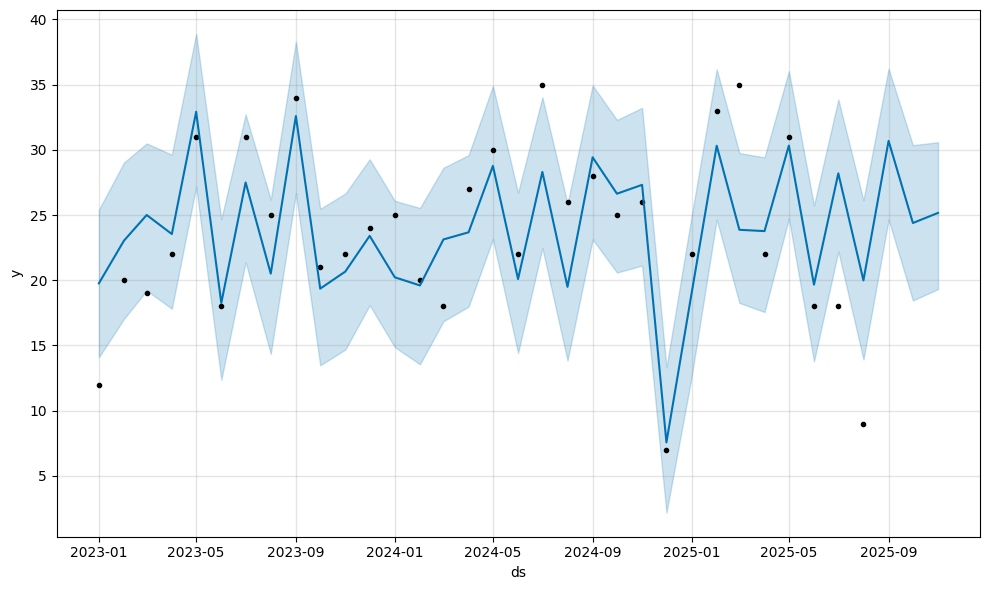

In [6]:
import pandas as pd
from prophet import Prophet

# Leer datos desde el archivo
url = "https://github.com/santiagonajera/MODELACION-Y-PRONOSTICOS-DE-LA-DEMANDA/raw/refs/heads/main/Ejemplo-supermercado.xlsx"
df = pd.read_excel(url)

# Preparar datos para Prophet
fechas = pd.date_range(start="2023-01-01", periods=len(df), freq='MS')
producto1 = df['PRODUCTO1'].values

data_prophet = pd.DataFrame({
    'ds': fechas,
    'y': producto1
})

# Ajustar modelo Prophet
model = Prophet()
model.fit(data_prophet)

# Forecast para los próximos 3 meses
future = model.make_future_dataframe(periods=3, freq='MS')
forecast = model.predict(future)

# Mostrar resultados
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6))

# Visualización
import matplotlib.pyplot as plt
model.plot(forecast)
plt.show()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfaj38bqv/886gwmup.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfaj38bqv/jv85kec4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56231', 'data', 'file=/tmp/tmpfaj38bqv/886gwmup.json', 'init=/tmp/tmpfaj38bqv/jv85kec4.json', 'output', 'file=/tmp/tmpfaj38bqv/prophet_model7qmus98m/prophet_model-20251023001815.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:18:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:18:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:

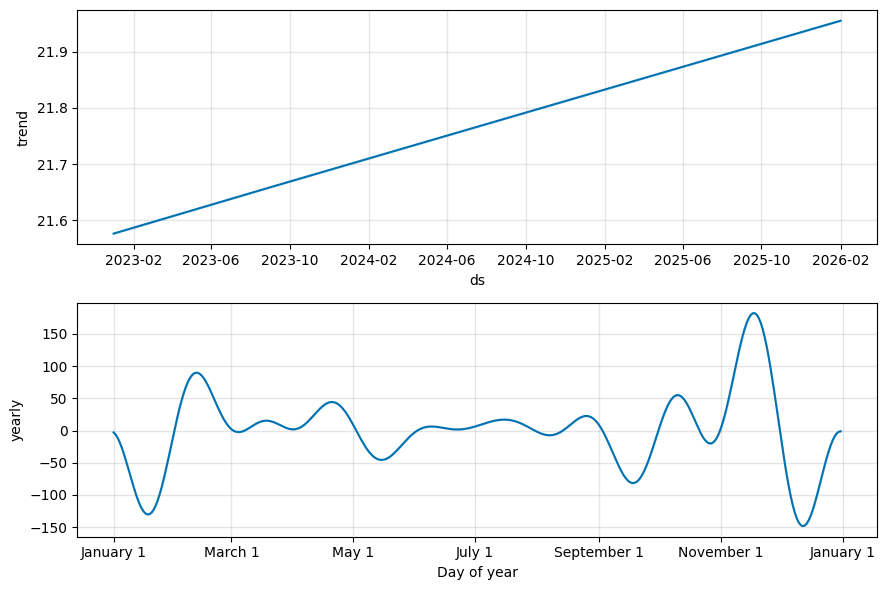

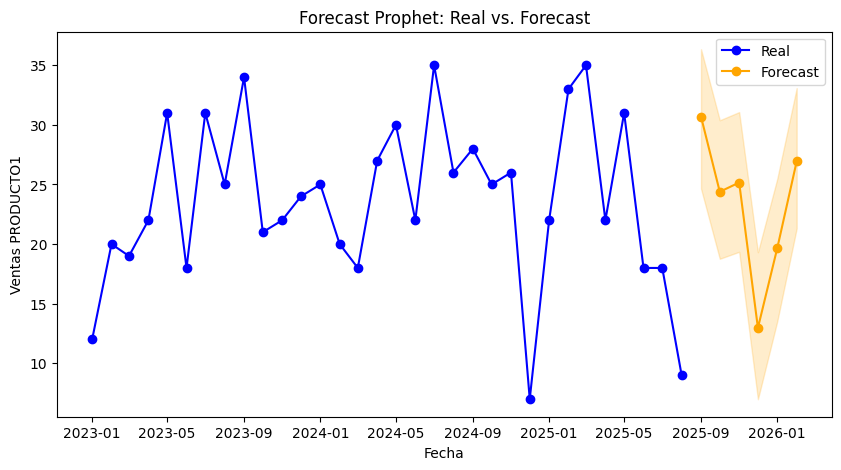

In [7]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Leer datos desde el archivo
url = "https://github.com/santiagonajera/MODELACION-Y-PRONOSTICOS-DE-LA-DEMANDA/raw/refs/heads/main/Ejemplo-supermercado.xlsx"
df = pd.read_excel(url)

# Preparar datos para Prophet
fechas = pd.date_range(start="2023-01-01", periods=len(df), freq='MS')
producto1 = df['PRODUCTO1'].values

data_prophet = pd.DataFrame({
    'ds': fechas,
    'y': producto1
})

# Ajustar modelo Prophet
model = Prophet()
model.fit(data_prophet)

# Forecast para los próximos 6 meses
future = model.make_future_dataframe(periods=6, freq='MS')
forecast = model.predict(future)

# Descomposición de componentes
fig_comp = model.plot_components(forecast)
plt.show()

# Gráfica con colores para real y forecast
plt.figure(figsize=(10,5))
plt.plot(data_prophet['ds'], data_prophet['y'], label="Real", color="blue", marker="o")
plt.plot(forecast['ds'][-6:], forecast['yhat'][-6:], label="Forecast", color="orange", marker="o")
plt.fill_between(forecast['ds'][-6:], forecast['yhat_lower'][-6:], forecast['yhat_upper'][-6:], color='orange', alpha=0.2)
plt.legend()
plt.xlabel("Fecha")
plt.ylabel("Ventas PRODUCTO1")
plt.title("Forecast Prophet: Real vs. Forecast")
plt.show()


In [9]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import warnings

warnings.filterwarnings("ignore")

# Carga
url = "https://github.com/santiagonajera/MODELACION-Y-PRONOSTICOS-DE-LA-DEMANDA/raw/refs/heads/main/Ejemplo-supermercado.xlsx"
df = pd.read_excel(url)
productos = [col for col in df.columns if "PRODUCTO" in col][:50]

# Funciones de modelos
def ses_forecast(series, alpha):
    result = [series[0]]
    for t in range(1, len(series)):
        result.append(alpha * series[t-1] + (1-alpha) * result[-1])
    return np.array(result)

def ses_rmse(alpha, series):
    fitted = ses_forecast(series, alpha)
    return np.sqrt(mean_squared_error(series[1:], fitted[:-1]))

def find_best_alpha(series):
    opt = minimize(lambda a: ses_rmse(a[0], series), x0=[0.5], bounds=[(0.01, 0.99)])
    return opt.x[0]

def croston(series, alpha=0.1):
    n = len(series)
    demand = np.array(series)
    idx = np.where(demand != 0)[0]
    if len(idx) == 0:
        return np.zeros(n)
    x = demand[idx]
    p = np.diff(np.concatenate(([0], idx)))
    a, b = x[0], p[0] if p[0]!=0 else 1
    forecasts = []
    for i in range(len(x)):
        a = a + alpha*(x[i]-a)
        b = b + alpha*(p[i]-b)
        b = max(b, 1e-6)
        forecasts.append(a/b)
    croston_fit = np.zeros(n)
    croston_fit[idx] = forecasts
    for i in range(n):
        if croston_fit[i] == 0 and i > 0:
            croston_fit[i] = croston_fit[i-1]
    croston_fit = np.nan_to_num(croston_fit, nan=0.0, posinf=0.0, neginf=0.0)
    return croston_fit

resultados = []

for prod in productos:
    serie = df[prod].values
    # SES
    alpha_opt = find_best_alpha(serie)
    ses_fit = ses_forecast(serie, alpha_opt)
    ses_rmse_val = ses_rmse(alpha_opt, serie)
    # CROSTON
    croston_fit = croston(serie)
    croston_fit = np.nan_to_num(croston_fit, nan=0.0, posinf=0.0, neginf=0.0)
    croston_rmse_val = np.sqrt(mean_squared_error(serie[1:], croston_fit[:-1]))
    # PROPHET
    fechas = pd.date_range(start="2023-01-01", periods=len(serie), freq='MS')
    data_prophet = pd.DataFrame({'ds': fechas, 'y': serie})
    model = Prophet()
    model.fit(data_prophet)
    forecast = model.predict(data_prophet)
    prophet_fit = forecast['yhat'].values
    prophet_rmse_val = np.sqrt(mean_squared_error(serie, prophet_fit))
    # Guardar resultados
    resultados.append({
        'Producto': prod,
        'SES_RMSE': ses_rmse_val,
        'Croston_RMSE': croston_rmse_val,
        'Prophet_RMSE': prophet_rmse_val,
        'Alpha_SES': alpha_opt
    })

resultados_df = pd.DataFrame(resultados)
print(resultados_df)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfaj38bqv/n6477ajx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfaj38bqv/ivcrai42.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83385', 'data', 'file=/tmp/tmpfaj38bqv/n6477ajx.json', 'init=/tmp/tmpfaj38bqv/ivcrai42.json', 'output', 'file=/tmp/tmpfaj38bqv/prophet_modelpj3iciqq/prophet_model-20251023002504.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
00:25:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:25:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:

      Producto   SES_RMSE  Croston_RMSE  Prophet_RMSE  Alpha_SES
0    PRODUCTO1   8.178778      8.122640      4.614989   0.329753
1    PRODUCTO2  10.135395     10.450212      3.908895   0.010000
2    PRODUCTO3   8.323114      9.543588      3.932867   0.278180
3    PRODUCTO4  10.563616     10.308268      6.434175   0.049677
4    PRODUCTO5   7.708076      7.564651      4.320473   0.094787
5    PRODUCTO6   9.706786      9.924978      5.151730   0.098756
6    PRODUCTO7   8.664829      9.516099      3.980834   0.191487
7    PRODUCTO8   8.964661      8.772846      5.714960   0.109973
8    PRODUCTO9   6.887447      6.951857      3.610749   0.010000
9   PRODUCTO10   8.146621      8.425847      3.399314   0.096100
10  PRODUCTO11   7.783768      8.106851      3.980311   0.010000
11  PRODUCTO12   8.183931      8.892480      4.509788   0.205954
12  PRODUCTO13   7.610088      7.481373      4.190711   0.067799
13  PRODUCTO14   7.882684      8.509262      1.806058   0.152404
14  PRODUCTO15   8.780679

In [11]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.5 MB/s eta 0:00:00


In [12]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import time
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from pmdarima import auto_arima

# Carga de datos (ajusta según tu contexto: url/local)
# df = pd.read_excel('VentasItermitentesYestables.xlsx') # si local
url = "https://github.com/santiagonajera/MODELACION-Y-PRONOSTICOS-DE-LA-DEMANDA/raw/refs/heads/main/VentasItermitentesYestables.xlsx"
df = pd.read_excel(url)

data = df['SKU001'].dropna().values
n = len(data)

resultados = {}
start = time.time()

# SES (alpha óptimo)
def ses_rmse(alpha):
    model = SimpleExpSmoothing(data).fit(smoothing_level=alpha, optimized=False)
    fitted = model.fittedvalues
    return np.sqrt(mean_squared_error(data[1:], fitted[:-1]))

alpha_opt = minimize(lambda x: ses_rmse(x[0]), x0=[0.5], bounds=[(0.01,0.99)]).x[0]
model_ses = SimpleExpSmoothing(data).fit(smoothing_level=alpha_opt, optimized=False)
ses_rmse_val = ses_rmse(alpha_opt)
resultados['SES_opt'] = ses_rmse_val

# Holt (alpha y beta)
model_holt = Holt(data).fit(optimized=True)
holt_rmse_val = np.sqrt(mean_squared_error(data, model_holt.fittedvalues))
resultados['Holt'] = holt_rmse_val

# Holt-Winters aditivo (alpha, beta, gamma)
model_hw_add = ExponentialSmoothing(data, trend="add", seasonal="add", seasonal_periods=2).fit()
hw_add_rmse_val = np.sqrt(mean_squared_error(data, model_hw_add.fittedvalues))
resultados['HW_add'] = hw_add_rmse_val

# Holt-Winters multiplicativo
model_hw_mul = ExponentialSmoothing(data, trend="mul", seasonal="mul", seasonal_periods=2).fit()
hw_mul_rmse_val = np.sqrt(mean_squared_error(data, model_hw_mul.fittedvalues))
resultados['HW_mul'] = hw_mul_rmse_val

# Promedio móvil 2 periodos
ma2 = pd.Series(data).rolling(window=2).mean().shift(1)
ma2_rmse_val = np.sqrt(mean_squared_error(data[1:], ma2[1:]))
resultados['MA2'] = ma2_rmse_val

# Croston SBA (básico)
def croston(series, alpha=0.1):
    n = len(series)
    demand = np.array(series)
    idx = np.where(demand != 0)[0]
    if len(idx) == 0:
        return np.zeros(n)
    x = demand[idx]
    p = np.diff(np.concatenate(([0], idx)))
    a, b = x[0], p[0] if p[0]!=0 else 1
    forecasts = []
    for i in range(len(x)):
        a = a + alpha*(x[i]-a)
        b = b + alpha*(p[i]-b)
        b = max(b, 1e-6)
        forecasts.append(a/b)
    croston_fit = np.zeros(n)
    croston_fit[idx] = forecasts
    for i in range(n):
        if croston_fit[i] == 0 and i > 0:
            croston_fit[i] = croston_fit[i-1]
    croston_fit = np.nan_to_num(croston_fit, nan=0.0, posinf=0.0, neginf=0.0)
    return croston_fit
croston_fit = croston(data)
croston_rmse_val = np.sqrt(mean_squared_error(data[1:], croston_fit[:-1]))
resultados['Croston'] = croston_rmse_val

# ADIDA (aggregate by period then SES, aquí solo agregamos por periodo=2 y corremos SES)
adida_data = pd.Series(data).groupby(np.arange(n)//2).sum().values
model_adida = SimpleExpSmoothing(adida_data).fit(optimized=True)
adida_fit = model_adida.fittedvalues
adida_full_fit = np.repeat(adida_fit, 2)[:n]
adida_rmse_val = np.sqrt(mean_squared_error(data, adida_full_fit))
resultados['ADIDA'] = adida_rmse_val

# ARIMA optimizado
arima_model = auto_arima(data, seasonal=False, suppress_warnings=True, stepwise=True)
arima_fitted = arima_model.predict_in_sample()
arima_rmse_val = np.sqrt(mean_squared_error(data, arima_fitted))
resultados['ARIMA'] = arima_rmse_val

# Prophet
fechas = pd.date_range(start="2023-01-01", periods=len(data), freq='W')
df_prophet = pd.DataFrame({'ds': fechas, 'y': data})
m_prophet = Prophet()
m_prophet.fit(df_prophet)
forecast_prophet = m_prophet.predict(df_prophet)
prophet_rmse_val = np.sqrt(mean_squared_error(data, forecast_prophet['yhat']))
resultados['Prophet'] = prophet_rmse_val

# Tiempo de ejecución total
elapsed = time.time() - start

# Resultados
resultados_df = pd.DataFrame(list(resultados.items()), columns=['Modelo','RMSE'])
mejor_modelo = resultados_df.loc[resultados_df['RMSE'].idxmin()].to_dict()

print(resultados_df)
print("\nMejor modelo:", mejor_modelo)
print("Tiempo total de ejecución: %.2f segundos" % elapsed)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [13]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import time
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, SARIMAX

# Cargar datos
url = "https://github.com/santiagonajera/MODELACION-Y-PRONOSTICOS-DE-LA-DEMANDA/raw/refs/heads/main/VentasItermitentesYestables.xlsx"
df = pd.read_excel(url)

data = df['SKU001'].dropna().values
n = len(data)

resultados = {}
start = time.time()

# SES (Simple Exponential Smoothing, alpha optimizado)
def ses_rmse(alpha):
    model = SimpleExpSmoothing(data).fit(smoothing_level=alpha, optimized=False)
    fitted = model.fittedvalues
    return np.sqrt(mean_squared_error(data[1:], fitted[:-1]))

alpha_opt = minimize(lambda x: ses_rmse(x[0]), x0=[0.5], bounds=[(0.01,0.99)]).x[0]
model_ses = SimpleExpSmoothing(data).fit(smoothing_level=alpha_opt, optimized=False)
ses_rmse_val = ses_rmse(alpha_opt)
resultados['SES_alpha_opt'] = ses_rmse_val

# Holt (alpha, beta optimizado)
model_holt = Holt(data).fit(optimized=True)
holt_rmse_val = np.sqrt(mean_squared_error(data, model_holt.fittedvalues))
resultados['Holt_alpha_beta'] = holt_rmse_val

# Holt-Winters aditivo (alpha, beta, gamma)
model_hw_add = ExponentialSmoothing(data, trend="add", seasonal="add", seasonal_periods=2).fit()
hw_add_rmse_val = np.sqrt(mean_squared_error(data, model_hw_add.fittedvalues))
resultados['HW_additive'] = hw_add_rmse_val

# Holt-Winters multiplicativo (alpha, beta, gamma)
model_hw_mul = ExponentialSmoothing(data, trend="mul", seasonal="mul", seasonal_periods=2).fit()
hw_mul_rmse_val = np.sqrt(mean_squared_error(data, model_hw_mul.fittedvalues))
resultados['HW_multiplicative'] = hw_mul_rmse_val

# Promedio móvil de dos periodos
ma2 = pd.Series(data).rolling(window=2).mean().shift(1)
ma2_rmse_val = np.sqrt(mean_squared_error(data[1:], ma2[1:]))
resultados['MA2'] = ma2_rmse_val

# Croston SBA
def croston(series, alpha=0.1):
    n = len(series)
    demand = np.array(series)
    idx = np.where(demand != 0)[0]
    if len(idx) == 0:
        return np.zeros(n)
    x = demand[idx]
    p = np.diff(np.concatenate(([0], idx)))
    a, b = x[0], p[0] if p[0]!=0 else 1
    forecasts = []
    for i in range(len(x)):
        a = a + alpha*(x[i]-a)
        b = b + alpha*(p[i]-b)
        b = max(b, 1e-6)
        forecasts.append(a/b)
    croston_fit = np.zeros(n)
    croston_fit[idx] = forecasts
    for i in range(n):
        if croston_fit[i] == 0 and i > 0:
            croston_fit[i] = croston_fit[i-1]
    croston_fit = np.nan_to_num(croston_fit, nan=0.0, posinf=0.0, neginf=0.0)
    return croston_fit
croston_fit = croston(data)
croston_rmse_val = np.sqrt(mean_squared_error(data[1:], croston_fit[:-1]))
resultados['Croston_SBA'] = croston_rmse_val

# ADIDA (agrupa por 2 periodos y SES)
adida_data = pd.Series(data).groupby(np.arange(n)//2).sum().values
model_adida = SimpleExpSmoothing(adida_data).fit(optimized=True)
adida_fit = model_adida.fittedvalues
adida_full_fit = np.repeat(adida_fit, 2)[:n]
adida_rmse_val = np.sqrt(mean_squared_error(data, adida_full_fit))
resultados['ADIDA'] = adida_rmse_val

# ARIMA (con SARIMAX de statsmodels, order optimizado manual básico por limitación)
model_arima = SARIMAX(data, order=(1,0,0)).fit(disp=False)
arima_fitted = model_arima.fittedvalues
arima_rmse_val = np.sqrt(mean_squared_error(data, arima_fitted))
resultados['ARIMA'] = arima_rmse_val

# Prophet
fechas = pd.date_range(start="2023-01-01", periods=n, freq='W')
df_prophet = pd.DataFrame({'ds': fechas, 'y': data})
m_prophet = Prophet()
m_prophet.fit(df_prophet)
forecast_prophet = m_prophet.predict(df_prophet)
prophet_rmse_val = np.sqrt(mean_squared_error(data, forecast_prophet['yhat']))
resultados['Prophet'] = prophet_rmse_val

elapsed = time.time() - start

resultados_df = pd.DataFrame(list(resultados.items()), columns=['Modelo','RMSE'])
mejor_modelo = resultados_df.loc[resultados_df['RMSE'].idxmin()].to_dict()

print(resultados_df)
print("\nMejor modelo:", mejor_modelo)
print("Tiempo total de ejecución: %.2f segundos" % elapsed)


ValueError: Input contains NaN.

In [14]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import time
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, SARIMAX

# Cargar datos
url = "https://github.com/santiagonajera/MODELACION-Y-PRONOSTICOS-DE-LA-DEMANDA/raw/refs/heads/main/VentasItermitentesYestables.xlsx"
df = pd.read_excel(url)

data = df['SKU001'].dropna().values
n = len(data)

resultados = {}
start = time.time()

# SES (Simple Exponential Smoothing, alpha optimizado)
def ses_rmse(alpha):
    model = SimpleExpSmoothing(data).fit(smoothing_level=alpha, optimized=False)
    fitted = model.fittedvalues
    return np.sqrt(mean_squared_error(data[1:], fitted[:-1]))

alpha_opt = minimize(lambda x: ses_rmse(x[0]), x0=[0.5], bounds=[(0.01,0.99)]).x[0]
model_ses = SimpleExpSmoothing(data).fit(smoothing_level=alpha_opt, optimized=False)
ses_rmse_val = ses_rmse(alpha_opt)
resultados['SES_alpha_opt'] = ses_rmse_val

# Holt (alpha, beta optimizado)
model_holt = Holt(data).fit(optimized=True)
holt_rmse_val = np.sqrt(mean_squared_error(data, model_holt.fittedvalues))
resultados['Holt_alpha_beta'] = holt_rmse_val

# Holt-Winters aditivo (alpha, beta, gamma)
model_hw_add = ExponentialSmoothing(data, trend="add", seasonal="add", seasonal_periods=2).fit()
hw_add_rmse_val = np.sqrt(mean_squared_error(data, model_hw_add.fittedvalues))
resultados['HW_additive'] = hw_add_rmse_val

# Holt-Winters multiplicativo (alpha, beta, gamma)
model_hw_mul = ExponentialSmoothing(data, trend="mul", seasonal="mul", seasonal_periods=2).fit()
hw_mul_rmse_val = np.sqrt(mean_squared_error(data, model_hw_mul.fittedvalues))
resultados['HW_multiplicative'] = hw_mul_rmse_val

# Promedio móvil de dos periodos (sin NaN)
ma2 = pd.Series(data).rolling(window=2).mean().shift(1)
ma2_valid = ma2.dropna()
data_ma2_valid = data[1:len(ma2_valid)+1]
ma2_rmse_val = np.sqrt(mean_squared_error(data_ma2_valid, ma2_valid))
resultados['MA2'] = ma2_rmse_val

# Croston SBA
def croston(series, alpha=0.1):
    n = len(series)
    demand = np.array(series)
    idx = np.where(demand != 0)[0]
    if len(idx) == 0:
        return np.zeros(n)
    x = demand[idx]
    p = np.diff(np.concatenate(([0], idx)))
    a, b = x[0], p[0] if p[0]!=0 else 1
    forecasts = []
    for i in range(len(x)):
        a = a + alpha*(x[i]-a)
        b = b + alpha*(p[i]-b)
        b = max(b, 1e-6)
        forecasts.append(a/b)
    croston_fit = np.zeros(n)
    croston_fit[idx] = forecasts
    for i in range(n):
        if croston_fit[i] == 0 and i > 0:
            croston_fit[i] = croston_fit[i-1]
    croston_fit = np.nan_to_num(croston_fit, nan=0.0, posinf=0.0, neginf=0.0)
    return croston_fit

croston_fit = croston(data)
croston_rmse_val = np.sqrt(mean_squared_error(data[1:], croston_fit[:-1]))
resultados['Croston_SBA'] = croston_rmse_val

# ADIDA (agrupa por 2 periodos y SES)
adida_data = pd.Series(data).groupby(np.arange(n)//2).sum().values
model_adida = SimpleExpSmoothing(adida_data).fit(optimized=True)
adida_fit = model_adida.fittedvalues
adida_full_fit = np.repeat(adida_fit, 2)[:n]
adida_rmse_val = np.sqrt(mean_squared_error(data, adida_full_fit))
resultados['ADIDA'] = adida_rmse_val

# ARIMA (con SARIMAX de statsmodels, order básico)
model_arima = SARIMAX(data, order=(1,0,0)).fit(disp=False)
arima_fitted = model_arima.fittedvalues
arima_rmse_val = np.sqrt(mean_squared_error(data, arima_fitted))
resultados['ARIMA'] = arima_rmse_val

# Prophet
fechas = pd.date_range(start="2023-01-01", periods=n, freq='W')
df_prophet = pd.DataFrame({'ds': fechas, 'y': data})
m_prophet = Prophet()
m_prophet.fit(df_prophet)
forecast_prophet = m_prophet.predict(df_prophet)
prophet_rmse_val = np.sqrt(mean_squared_error(data, forecast_prophet['yhat']))
resultados['Prophet'] = prophet_rmse_val

elapsed = time.time() - start

resultados_df = pd.DataFrame(list(resultados.items()), columns=['Modelo','RMSE'])
mejor_modelo = resultados_df.loc[resultados_df['RMSE'].idxmin()].to_dict()

print(resultados_df)
print("\nMejor modelo:", mejor_modelo)
print("Tiempo total de ejecución: %.2f segundos" % elapsed)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfaj38bqv/hw17odzs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfaj38bqv/7g_0_750.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14413', 'data', 'file=/tmp/tmpfaj38bqv/hw17odzs.json', 'init=/tmp/tmpfaj38bqv/7g_0_750.json', 'output', 'file=/tmp/tmpfaj38bqv/prophet_modelwbdybiv2/prophet_model-20251023005455.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:54:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:54:55 - cmdstanpy - INFO - Chain

              Modelo       RMSE
0      SES_alpha_opt   2.075451
1    Holt_alpha_beta   2.360243
2        HW_additive   2.017290
3  HW_multiplicative   2.017305
4                MA2   1.381779
5        Croston_SBA   2.110918
6              ADIDA  13.300584
7              ARIMA   3.012403
8            Prophet   2.018109

Mejor modelo: {'Modelo': 'MA2', 'RMSE': 1.3817791883981305}
Tiempo total de ejecución: 1.82 segundos


In [15]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import time
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, SARIMAX

# Cargar datos
url = "https://github.com/santiagonajera/MODELACION-Y-PRONOSTICOS-DE-LA-DEMANDA/raw/refs/heads/main/VentasItermitentesYestables.xlsx"
df = pd.read_excel(url)

productos = ['SKU001', 'SKU002']
nombres = ['SKU001', 'SKU002']

def calcular_modelos(data, nombre, freq='W', fecha_ini="2023-01-01"):
    n = len(data)
    resultados = {}
    # SES (Simple Exponential Smoothing, alpha optimizado)
    def ses_rmse(alpha):
        model = SimpleExpSmoothing(data).fit(smoothing_level=alpha, optimized=False)
        fitted = model.fittedvalues
        return np.sqrt(mean_squared_error(data[1:], fitted[:-1]))
    alpha_opt = minimize(lambda x: ses_rmse(x[0]), x0=[0.5], bounds=[(0.01,0.99)]).x[0]
    model_ses = SimpleExpSmoothing(data).fit(smoothing_level=alpha_opt, optimized=False)
    ses_rmse_val = ses_rmse(alpha_opt)
    resultados['SES_alpha_opt'] = ses_rmse_val

    # Holt (alpha, beta optimizado)
    model_holt = Holt(data).fit(optimized=True)
    holt_rmse_val = np.sqrt(mean_squared_error(data, model_holt.fittedvalues))
    resultados['Holt_alpha_beta'] = holt_rmse_val

    # Holt-Winters aditivo (alpha, beta, gamma)
    model_hw_add = ExponentialSmoothing(data, trend="add", seasonal="add", seasonal_periods=2).fit()
    hw_add_rmse_val = np.sqrt(mean_squared_error(data, model_hw_add.fittedvalues))
    resultados['HW_additive'] = hw_add_rmse_val

    # Holt-Winters multiplicativo (alpha, beta, gamma)
    model_hw_mul = ExponentialSmoothing(data, trend="mul", seasonal="mul", seasonal_periods=2).fit()
    hw_mul_rmse_val = np.sqrt(mean_squared_error(data, model_hw_mul.fittedvalues))
    resultados['HW_multiplicative'] = hw_mul_rmse_val

    # Promedio móvil de dos periodos (sin NaN)
    ma2 = pd.Series(data).rolling(window=2).mean().shift(1)
    ma2_valid = ma2.dropna()
    data_ma2_valid = data[1:len(ma2_valid)+1]
    ma2_rmse_val = np.sqrt(mean_squared_error(data_ma2_valid, ma2_valid))
    resultados['MA2'] = ma2_rmse_val

    # Croston SBA
    def croston(series, alpha=0.1):
        n = len(series)
        demand = np.array(series)
        idx = np.where(demand != 0)[0]
        if len(idx) == 0:
            return np.zeros(n)
        x = demand[idx]
        p = np.diff(np.concatenate(([0], idx)))
        a, b = x[0], p[0] if p[0]!=0 else 1
        forecasts = []
        for i in range(len(x)):
            a = a + alpha*(x[i]-a)
            b = b + alpha*(p[i]-b)
            b = max(b, 1e-6)
            forecasts.append(a/b)
        croston_fit = np.zeros(n)
        croston_fit[idx] = forecasts
        for i in range(n):
            if croston_fit[i] == 0 and i > 0:
                croston_fit[i] = croston_fit[i-1]
        croston_fit = np.nan_to_num(croston_fit, nan=0.0, posinf=0.0, neginf=0.0)
        return croston_fit
    croston_fit = croston(data)
    croston_rmse_val = np.sqrt(mean_squared_error(data[1:], croston_fit[:-1]))
    resultados['Croston_SBA'] = croston_rmse_val

    # ADIDA (agrega por 2 periodos y SES)
    adida_data = pd.Series(data).groupby(np.arange(n)//2).sum().values
    model_adida = SimpleExpSmoothing(adida_data).fit(optimized=True)
    adida_fit = model_adida.fittedvalues
    adida_full_fit = np.repeat(adida_fit, 2)[:n]
    adida_rmse_val = np.sqrt(mean_squared_error(data, adida_full_fit))
    resultados['ADIDA'] = adida_rmse_val

    # ARIMA (con SARIMAX de statsmodels, order básico)
    model_arima = SARIMAX(data, order=(1,0,0)).fit(disp=False)
    arima_fitted = model_arima.fittedvalues
    arima_rmse_val = np.sqrt(mean_squared_error(data, arima_fitted))
    resultados['ARIMA'] = arima_rmse_val

    # Prophet
    fechas = pd.date_range(start=fecha_ini, periods=n, freq=freq)
    df_prophet = pd.DataFrame({'ds': fechas, 'y': data})
    m_prophet = Prophet()
    m_prophet.fit(df_prophet)
    forecast_prophet = m_prophet.predict(df_prophet)
    prophet_rmse_val = np.sqrt(mean_squared_error(data, forecast_prophet['yhat']))
    resultados['Prophet'] = prophet_rmse_val

    return resultados

# Medir tiempo de ejecución total
start = time.time()

todos_resultados = []

for prod in productos:
    data = df[prod].dropna().values
    resultado = calcular_modelos(data, prod)
    modelo_ganador = min(resultado, key=resultado.get)
    todos_resultados.append({'Producto': prod, **resultado, 'Mejor_Modelo': modelo_ganador})

elapsed = time.time() - start

df_final = pd.DataFrame(todos_resultados)
print(df_final)
print("Tiempo total de ejecución: %.2f segundos" % elapsed)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfaj38bqv/_7zo47om.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfaj38bqv/umr2xfgk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6491', 'data', 'file=/tmp/tmpfaj38bqv/_7zo47om.json', 'init=/tmp/tmpfaj38bqv/umr2xfgk.json', 'output', 'file=/tmp/tmpfaj38bqv/prophet_modeldfxyn1dj/prophet_model-20251023010030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:00:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:00:30 - cmdstanpy - INFO - Chain 

ValueError: endog must be strictly positive when usingmultiplicative trend or seasonal components.

In [16]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import time
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, SARIMAX

# Cargar datos
url = "https://github.com/santiagonajera/MODELACION-Y-PRONOSTICOS-DE-LA-DEMANDA/raw/refs/heads/main/VentasItermitentesYestables.xlsx"
df = pd.read_excel(url)

productos = ['SKU001', 'SKU002']

def calcular_modelos(data, nombre, freq='W', fecha_ini="2023-01-01"):
    n = len(data)
    resultados = {}
    # SES (Simple Exponential Smoothing, alpha optimizado)
    def ses_rmse(alpha):
        model = SimpleExpSmoothing(data).fit(smoothing_level=alpha, optimized=False)
        fitted = model.fittedvalues
        return np.sqrt(mean_squared_error(data[1:], fitted[:-1]))
    alpha_opt = minimize(lambda x: ses_rmse(x[0]), x0=[0.5], bounds=[(0.01,0.99)]).x[0]
    model_ses = SimpleExpSmoothing(data).fit(smoothing_level=alpha_opt, optimized=False)
    ses_rmse_val = ses_rmse(alpha_opt)
    resultados['SES_alpha_opt'] = ses_rmse_val

    # Holt (alpha, beta optimizado)
    model_holt = Holt(data).fit(optimized=True)
    holt_rmse_val = np.sqrt(mean_squared_error(data, model_holt.fittedvalues))
    resultados['Holt_alpha_beta'] = holt_rmse_val

    # Holt-Winters aditivo (alpha, beta, gamma)
    model_hw_add = ExponentialSmoothing(data, trend="add", seasonal="add", seasonal_periods=2).fit()
    hw_add_rmse_val = np.sqrt(mean_squared_error(data, model_hw_add.fittedvalues))
    resultados['HW_additive'] = hw_add_rmse_val

    # Holt-Winters multiplicativo (solo si datos > 0)
    if np.all(data > 0):
        model_hw_mul = ExponentialSmoothing(data, trend="mul", seasonal="mul", seasonal_periods=2).fit()
        hw_mul_rmse_val = np.sqrt(mean_squared_error(data, model_hw_mul.fittedvalues))
    else:
        hw_mul_rmse_val = np.nan
    resultados['HW_multiplicative'] = hw_mul_rmse_val

    # Promedio móvil de dos periodos (sin NaN)
    ma2 = pd.Series(data).rolling(window=2).mean().shift(1)
    ma2_valid = ma2.dropna()
    data_ma2_valid = data[1:len(ma2_valid)+1]
    ma2_rmse_val = np.sqrt(mean_squared_error(data_ma2_valid, ma2_valid))
    resultados['MA2'] = ma2_rmse_val

    # Croston SBA
    def croston(series, alpha=0.1):
        n = len(series)
        demand = np.array(series)
        idx = np.where(demand != 0)[0]
        if len(idx) == 0:
            return np.zeros(n)
        x = demand[idx]
        p = np.diff(np.concatenate(([0], idx)))
        a, b = x[0], p[0] if p[0]!=0 else 1
        forecasts = []
        for i in range(len(x)):
            a = a + alpha*(x[i]-a)
            b = b + alpha*(p[i]-b)
            b = max(b, 1e-6)
            forecasts.append(a/b)
        croston_fit = np.zeros(n)
        croston_fit[idx] = forecasts
        for i in range(n):
            if croston_fit[i] == 0 and i > 0:
                croston_fit[i] = croston_fit[i-1]
        croston_fit = np.nan_to_num(croston_fit, nan=0.0, posinf=0.0, neginf=0.0)
        return croston_fit
    croston_fit = croston(data)
    croston_rmse_val = np.sqrt(mean_squared_error(data[1:], croston_fit[:-1]))
    resultados['Croston_SBA'] = croston_rmse_val

    # ADIDA (agrega por 2 periodos y SES)
    adida_data = pd.Series(data).groupby(np.arange(n)//2).sum().values
    model_adida = SimpleExpSmoothing(adida_data).fit(optimized=True)
    adida_fit = model_adida.fittedvalues
    adida_full_fit = np.repeat(adida_fit, 2)[:n]
    adida_rmse_val = np.sqrt(mean_squared_error(data, adida_full_fit))
    resultados['ADIDA'] = adida_rmse_val

    # ARIMA (SARIMAX de statsmodels, order básico)
    model_arima = SARIMAX(data, order=(1,0,0)).fit(disp=False)
    arima_fitted = model_arima.fittedvalues
    arima_rmse_val = np.sqrt(mean_squared_error(data, arima_fitted))
    resultados['ARIMA'] = arima_rmse_val

    # Prophet
    fechas = pd.date_range(start=fecha_ini, periods=n, freq=freq)
    df_prophet = pd.DataFrame({'ds': fechas, 'y': data})
    m_prophet = Prophet()
    m_prophet.fit(df_prophet)
    forecast_prophet = m_prophet.predict(df_prophet)
    prophet_rmse_val = np.sqrt(mean_squared_error(data, forecast_prophet['yhat']))
    resultados['Prophet'] = prophet_rmse_val

    return resultados

start = time.time()

todos_resultados = []
for prod in productos:
    data = df[prod].dropna().values
    resultado = calcular_modelos(data, prod)
    modelo_ganador = min(resultado, key=lambda k: resultado[k] if not np.isnan(resultado[k]) else np.inf)
    todos_resultados.append({'Producto': prod, **resultado, 'Mejor_Modelo': modelo_ganador})

elapsed = time.time() - start

df_final = pd.DataFrame(todos_resultados)
print(df_final)
print("Tiempo total de ejecución: %.2f segundos" % elapsed)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfaj38bqv/54gy0il8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfaj38bqv/n345g8hp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27310', 'data', 'file=/tmp/tmpfaj38bqv/54gy0il8.json', 'init=/tmp/tmpfaj38bqv/n345g8hp.json', 'output', 'file=/tmp/tmpfaj38bqv/prophet_modelp4yal_gg/prophet_model-20251023010124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:01:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:01:24 - cmdstanpy - INFO - Chain

  Producto  SES_alpha_opt  Holt_alpha_beta  HW_additive  HW_multiplicative  \
0   SKU001       2.075451         2.360243     2.017290           2.017305   
1   SKU002       4.467711         4.417443     4.145085                NaN   

        MA2  Croston_SBA      ADIDA     ARIMA   Prophet Mejor_Modelo  
0  1.381779     2.110918  13.300584  3.012403  2.018109          MA2  
1  2.234972     4.425544  17.355447  4.726576  4.275060          MA2  
Tiempo total de ejecución: 1.88 segundos


In [17]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import time
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt, SARIMAX

# Cargar datos
url = "https://github.com/santiagonajera/MODELACION-Y-PRONOSTICOS-DE-LA-DEMANDA/raw/refs/heads/main/VentasItermitentesYestables.xlsx"
df = pd.read_excel(url)

productos = [col for col in df.columns if col != 'Semana']

def calcular_modelos(data, freq='W', fecha_ini="2023-01-01"):
    n = len(data)
    resultados = {}
    # SES
    def ses_rmse(alpha):
        model = SimpleExpSmoothing(data).fit(smoothing_level=alpha, optimized=False)
        fitted = model.fittedvalues
        return np.sqrt(mean_squared_error(data[1:], fitted[:-1]))
    alpha_opt = minimize(lambda x: ses_rmse(x[0]), x0=[0.5], bounds=[(0.01,0.99)]).x[0]
    model_ses = SimpleExpSmoothing(data).fit(smoothing_level=alpha_opt, optimized=False)
    ses_rmse_val = ses_rmse(alpha_opt)
    resultados['SES_alpha_opt'] = ses_rmse_val

    # Holt
    model_holt = Holt(data).fit(optimized=True)
    holt_rmse_val = np.sqrt(mean_squared_error(data, model_holt.fittedvalues))
    resultados['Holt_alpha_beta'] = holt_rmse_val

    # Holt-Winters aditivo
    model_hw_add = ExponentialSmoothing(data, trend="add", seasonal="add", seasonal_periods=2).fit()
    hw_add_rmse_val = np.sqrt(mean_squared_error(data, model_hw_add.fittedvalues))
    resultados['HW_additive'] = hw_add_rmse_val

    # Holt-Winters multiplicativo solo si data positiva
    if np.all(data > 0):
        model_hw_mul = ExponentialSmoothing(data, trend="mul", seasonal="mul", seasonal_periods=2).fit()
        hw_mul_rmse_val = np.sqrt(mean_squared_error(data, model_hw_mul.fittedvalues))
    else:
        hw_mul_rmse_val = np.nan
    resultados['HW_multiplicative'] = hw_mul_rmse_val

    # Promedio móvil 2 periodos
    ma2 = pd.Series(data).rolling(window=2).mean().shift(1)
    ma2_valid = ma2.dropna()
    data_ma2_valid = data[1:len(ma2_valid)+1]
    ma2_rmse_val = np.sqrt(mean_squared_error(data_ma2_valid, ma2_valid))
    resultados['MA2'] = ma2_rmse_val

    # Croston SBA
    def croston(series, alpha=0.1):
        n = len(series)
        demand = np.array(series)
        idx = np.where(demand != 0)[0]
        if len(idx) == 0:
            return np.zeros(n)
        x = demand[idx]
        p = np.diff(np.concatenate(([0], idx)))
        a, b = x[0], p[0] if p[0]!=0 else 1
        forecasts = []
        for i in range(len(x)):
            a = a + alpha*(x[i]-a)
            b = b + alpha*(p[i]-b)
            b = max(b, 1e-6)
            forecasts.append(a/b)
        croston_fit = np.zeros(n)
        croston_fit[idx] = forecasts
        for i in range(n):
            if croston_fit[i] == 0 and i > 0:
                croston_fit[i] = croston_fit[i-1]
        croston_fit = np.nan_to_num(croston_fit, nan=0.0, posinf=0.0, neginf=0.0)
        return croston_fit
    croston_fit = croston(data)
    croston_rmse_val = np.sqrt(mean_squared_error(data[1:], croston_fit[:-1]))
    resultados['Croston_SBA'] = croston_rmse_val

    # ADIDA
    adida_data = pd.Series(data).groupby(np.arange(n)//2).sum().values
    model_adida = SimpleExpSmoothing(adida_data).fit(optimized=True)
    adida_fit = model_adida.fittedvalues
    adida_full_fit = np.repeat(adida_fit, 2)[:n]
    adida_rmse_val = np.sqrt(mean_squared_error(data, adida_full_fit))
    resultados['ADIDA'] = adida_rmse_val

    # ARIMA (SARIMAX básico)
    model_arima = SARIMAX(data, order=(1,0,0)).fit(disp=False)
    arima_fitted = model_arima.fittedvalues
    arima_rmse_val = np.sqrt(mean_squared_error(data, arima_fitted))
    resultados['ARIMA'] = arima_rmse_val

    # Prophet
    fechas = pd.date_range(start=fecha_ini, periods=n, freq=freq)
    df_prophet = pd.DataFrame({'ds': fechas, 'y': data})
    m_prophet = Prophet()
    m_prophet.fit(df_prophet)
    forecast_prophet = m_prophet.predict(df_prophet)
    prophet_rmse_val = np.sqrt(mean_squared_error(data, forecast_prophet['yhat']))
    resultados['Prophet'] = prophet_rmse_val

    return resultados

start = time.time()

todos_resultados = []

for prod in productos:
    data = df[prod].dropna().values
    resultado = calcular_modelos(data)
    modelo_ganador = min(resultado, key=lambda k: resultado[k] if not np.isnan(resultado[k]) else np.inf)
    todos_resultados.append({'Producto': prod, **resultado, 'Mejor_Modelo': modelo_ganador})

elapsed = time.time() - start

df_final = pd.DataFrame(todos_resultados)
print(df_final)
print("Tiempo total de ejecución: %.2f segundos" % elapsed)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfaj38bqv/1sm3n__a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfaj38bqv/6dg3zw2k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19212', 'data', 'file=/tmp/tmpfaj38bqv/1sm3n__a.json', 'init=/tmp/tmpfaj38bqv/6dg3zw2k.json', 'output', 'file=/tmp/tmpfaj38bqv/prophet_modelbq7i97p_/prophet_model-20251023010337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:03:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:03:37 - cmdstanpy - INFO - Chain

   Producto  SES_alpha_opt  Holt_alpha_beta  HW_additive  HW_multiplicative  \
0    SKU001       2.075451         2.360243     2.017290           2.017305   
1    SKU002       4.467711         4.417443     4.145085                NaN   
2    SKU003       2.816932         3.297902     2.622677           2.624187   
3    SKU004       5.799380         6.318116     5.660162                NaN   
4    SKU005       2.379084         2.662085     2.177816           2.177806   
5    SKU006       2.818426         3.417710     2.529239           2.529430   
6    SKU007      12.400997        14.159429    11.285674                NaN   
7    SKU008       9.931225        11.742122     9.680910                NaN   
8    SKU009       9.480982        12.938434     9.030693           9.031028   
9    SKU010       7.044910         8.227204     6.570053                NaN   
10   SKU011      10.797213        11.863500    10.288190          10.782997   
11   SKU012       8.586407        10.208447     8.32